In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [18]:
def unify_query_strategies(df):
    """
    Unifies 'PeriodicSampling' and 'StreamRandomSampling' strategies into a 
    single 'baseline' strategy by averaging their 'final_accuracy'.

    The grouping is performed based on all other columns except 'query_strategy' 
    and 'final_accuracy'.

    Args:
        df: The input DataFrame containing active learning experiment results.

    Returns:
        A new DataFrame with the unified 'baseline' strategy replacing the 
        two original strategies.
    """
    
    strategies_to_unify = ['PeriodicSampling', 'StreamRandomSampling']
    new_strategy_name = 'Baseline'

    all_cols = df.columns.tolist()
    
    required_cols = ['query_strategy', 'final_accuracy']
    if not all(col in all_cols for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")

    grouping_keys = [col for col in all_cols 
                     if col not in ['query_strategy', 'final_accuracy']]
    
    df_to_unify = df[df['query_strategy'].isin(strategies_to_unify)].copy()

    df_baseline = df_to_unify.groupby(grouping_keys, as_index=False)['final_accuracy'].mean()

    df_baseline['query_strategy'] = new_strategy_name
    
    df_baseline = df_baseline[all_cols]

    df_others = df[~df['query_strategy'].isin(strategies_to_unify)].copy()

    df_union_new = pd.concat([df_others, df_baseline], ignore_index=True)

    return df_union_new



def calculate_p_values(df_unified: pd.DataFrame) -> dict:
    """
    Calculates the two-sample independent t-test p-value for each query strategy 
    against the 'baseline' strategy, comparing their 'final_accuracy' populations.

    Args:
        df_unified: The DataFrame containing active learning results.

    Returns:
        A dictionary where keys are query strategies and values are their 
        calculated p-values against the baseline.
    """
    p_values = {}
    strategies = df_unified['query_strategy'].unique()
    
    # Extract the full population of baseline accuracies for comparison
    df_baseline_acc = df_unified[df_unified['query_strategy'] == 'Baseline']['final_accuracy']
    
    for strategy in strategies:
        if strategy == 'Baseline':
            p_values[strategy] = 1.0
            continue
        
        # Check if the baseline population is large enough for a t-test
        if len(df_baseline_acc) > 1:
            # Extract the full population of the current strategy's accuracies
            df_strategy_acc = df_unified[df_unified['query_strategy'] == strategy]['final_accuracy']
            
            # Check if the current strategy population is large enough for a t-test
            if len(df_strategy_acc) > 1:
                try:
                    # Perform an Independent Two-Sample T-Test (assuming unequal variances)
                    # We compare the entire accuracy distribution of each strategy to the baseline
                    stat, p = ttest_ind(df_strategy_acc, df_baseline_acc, equal_var=False)
                    p_values[strategy] = p
                except Exception:
                    # Catch any numerical errors during T-test calculation
                    p_values[strategy] = np.nan
            else:
                p_values[strategy] = np.nan # Not enough data in this strategy group
        else:
            p_values[strategy] = np.nan # Not enough data in baseline group

    print("\n--- Calculated P-Values (vs. Baseline) ---")
    print({k: f"{v:.4f}" if pd.notna(v) else "N/A" for k, v in p_values.items()})
    print("------------------------------------------")
    
    return p_values



def plot_accuracy_vs_budget(df_unified: pd.DataFrame, p_values: dict, title: str):
    """
    Plots final_accuracy vs. budget, applying custom styles to specific strategies
    and including the p-value (compared to baseline) in the legend.

    Args:
        df_unified: The DataFrame containing the unified active learning results.
        p_values: A dictionary of p-values for each strategy vs. baseline.
    """
    
    # 1. Prepare data for plotting: Calculate mean accuracy for each (strategy, budget) pair
    # This averages the accuracies for the line plot
    df_plot = df_unified.groupby(['query_strategy', 'budget'])['final_accuracy'].mean().reset_index()
    
    # Identify unique strategies for iterating and styling
    strategies = df_plot['query_strategy'].unique()

    # --- Setup Plot ---
    plt.figure(figsize=(10, 6))
    
    # Define custom styling and base labels
    CUSTOM_STYLES = {
        'Baseline': {'linestyle': ':', 'color': 'black', 'base_label': 'Baseline (Ref.)'}, 
    }

    # --- Handle the 'NONE: BUDGET = 1' horizontal line separately (No P-value) ---
    NONE_STRATEGY = 'NONE: BUDGET = 1'
    if NONE_STRATEGY in strategies:
        # 1. Get the single accuracy value for the NONE strategy
        none_subset = df_plot[df_plot['query_strategy'] == NONE_STRATEGY]
        if not none_subset.empty:
            # Assumes the mean for NONE: BUDGET = 1 is a single value
            none_accuracy = none_subset['final_accuracy'].iloc[0]
            
            # 2. Construct the label *WITHOUT* the p-value
            final_label_none = 'Full Budget (Ref.)' # Direct label
            
            # 3. Plot the horizontal line using plt.axhline
            plt.axhline(
                y=none_accuracy, 
                color='black', 
                linestyle='--', 
                label=final_label_none, # Use the label without p-value
                linewidth=2
            )
            # Remove this strategy from the main plotting loop
            strategies = [s for s in strategies if s != NONE_STRATEGY]


    # Use a color palette for other strategies (excluding the ones handled)
    other_strategies = [s for s in strategies if s not in CUSTOM_STYLES]
    # Generate a color map for the remaining strategies
    colors = sns.color_palette("husl", len(other_strategies))
    color_map = {s: c for s, c in zip(other_strategies, colors)}
    
    # --- Plotting Loop for non-horizontal lines (Active Learning Strategies) ---
    for i, strategy in enumerate(strategies):
        subset = df_plot[df_plot['query_strategy'] == strategy]
        
        style = CUSTOM_STYLES.get(strategy, {})
        
        # Determine the base label, color, and linestyle
        if strategy in CUSTOM_STYLES:
            base_label = style['base_label']
            color = style['color']
            linestyle = style['linestyle']
        else:
            base_label = strategy
            color = color_map[strategy]
            linestyle = '-' # Solid line for all others

        # Construct the final label including the p-value (for all *other* strategies)
        p_value = p_values.get(strategy, np.nan)
        if strategy == 'Baseline':
            final_label = base_label
        elif pd.notna(p_value):
            # Include p-value formatted to 3 decimal places
            final_label = f"{base_label} (p={p_value:.3f})"
        else:
            final_label = f"{base_label} (p=N/A)" # Handle cases with insufficient data

        plt.plot(
            subset['budget'], 
            subset['final_accuracy'], 
            label=final_label, 
            color=color, 
            linestyle=linestyle,
            marker='o', # Add markers for clarity
            linewidth=2
        )

    # --- Final Plot Customization ---
    
    # Set labels and title
    plt.title(f'Final Accuracy vs. Budget by Query Strategy for {title} datasets', fontsize=16, fontweight='bold')
    plt.xlabel('Budget', fontsize=14)
    plt.ylabel('Final Accuracy', fontsize=14)
    
    # Add grid, legend, and context
    plt.grid(True, linestyle='--', alpha=0.6)
    # The legend title still reflects the p-value comparison for the AL strategies
    plt.legend(title=f'Query Strategy (p-value vs. Baseline)', loc='lower right', frameon=True, shadow=True, fontsize=10)
    plt.minorticks_on()
    
    # Set y-axis limits to start from a reasonable minimum and end slightly above max accuracy
    max_acc = df_plot['final_accuracy'].max()
    min_acc = df_plot['final_accuracy'].min()
    plt.ylim(min_acc * 0.95, max_acc * 1.02)
    
    plt.tight_layout()
    plt.show()

def calculate_p_values_per_budget(df_unified: pd.DataFrame) -> dict:
    """
    Calculates the two-sample independent t-test p-value for each query strategy 
    against the 'baseline' strategy, scoped per unique budget level.

    Args:
        df_unified: The DataFrame containing active learning results.

    Returns:
        A dictionary structured as {budget: {strategy: p_value, ...}, ...}.
    """
    p_values_per_budget = {}
    unique_budgets = df_unified['budget'].unique()
    strategies = df_unified['query_strategy'].unique()

    print("\n--- Calculated P-Values (vs. Baseline) ---")

    for budget in sorted(unique_budgets):
        p_values_per_budget[budget] = {}
        df_budget = df_unified[df_unified['budget'] == budget]
        df_baseline_acc = df_budget[df_budget['query_strategy'] == 'Baseline']['final_accuracy']
        
        print(f"Budget={budget}:", end=" ")

        for strategy in strategies:
            if strategy == 'Baseline':
                p_values_per_budget[budget][strategy] = 1.0
                continue

            df_strategy_acc = df_budget[df_budget['query_strategy'] == strategy]['final_accuracy']
            p = np.nan
            
            # Require at least 2 samples in both groups for a valid t-test
            if len(df_baseline_acc) > 1 and len(df_strategy_acc) > 1:
                try:
                    stat, p = ttest_ind(df_strategy_acc, df_baseline_acc, equal_var=False)
                except Exception:
                    p = np.nan
            
            p_values_per_budget[budget][strategy] = p
            print(f" {strategy} p={p:.3f}" if pd.notna(p) else f" {strategy} p=N/A", end=" |")

        print() # Newline after finishing a budget
    
    print("------------------------------------------")
    return p_values_per_budget

def plot_strategies_per_budget(df_unified: pd.DataFrame, p_values_per_budget: dict, target_budget: int):
    """
    Creates a single bar plot for a specific budget level, showing 
    mean accuracy per strategy and displaying p-values vs. the baseline.

    Args:
        df_unified: The DataFrame containing the unified active learning results.
        p_values_per_budget: A dictionary of p-values scoped per budget.
        target_budget: The specific budget level (int) to plot.
    """
    
    # Calculate mean accuracy for the bar heights
    df_plot = df_unified.groupby(['query_strategy', 'budget'])['final_accuracy'].mean().reset_index()
    
    # Filter data for the target budget
    df_budget_plot = df_plot[df_plot['budget'] == target_budget].copy()

    if df_budget_plot.empty:
        print(f"Error: No data found for budget level {target_budget}. Cannot generate plot.")
        return

    # Set up the single figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Find the min/max accuracy for the selected budget for consistent Y-axis limits
    max_acc = df_budget_plot['final_accuracy'].max()
    min_acc = df_budget_plot['final_accuracy'].min()
    y_min = 0
    y_max = 1

    # Define color palette for strategies
    strategies = df_budget_plot['query_strategy'].unique()
    palette = {s: c for s, c in zip(strategies, sns.color_palette("Set2", len(strategies)))}

    budget = target_budget # Use the target budget

    # Sort strategies to ensure baseline is easily identifiable
    baseline_row = df_budget_plot[df_budget_plot['query_strategy'] == 'Baseline']
    other_rows = df_budget_plot[df_budget_plot['query_strategy'] != 'Baseline']
    
    # Force a consistent order (Baseline, then alphabetical)
    df_budget_plot_sorted = pd.concat([baseline_row, other_rows.sort_values(by='query_strategy')])
    
    # 1. Create the bar plot for the current budget
    sns.barplot(
        x='query_strategy', 
        y='final_accuracy', 
        data=df_budget_plot_sorted, 
        ax=ax, 
        palette=palette,
        hue='query_strategy', 
        legend=False
    )

    # 2. Add custom labels (p-values) above the bars
    for patch in ax.patches:
        # Determine the strategy name based on the plotting order
        strategy_name = df_budget_plot_sorted['query_strategy'].iloc[ax.patches.index(patch)]
        accuracy_mean = patch.get_height()
        
        p_val = p_values_per_budget.get(budget, {}).get(strategy_name, np.nan)
        
        # Format the p-value label
        if strategy_name == 'Baseline':
            label = 'Ref.'
            color = 'black'
        elif strategy_name == 'NONE: BUDGET = 1':
             label = 'Full Budget'
             color = 'black'
        elif pd.notna(p_val):
            label = f"p={p_val:.3f}"
            # Highlight significant p-values (e.g., p < 0.05)
            color = 'red' if p_val < 0.05 else 'darkgreen' 
        else:
            label = 'p=N/A'
            color = 'gray'

        # Add the text label slightly above the bar
        ax.text(
            patch.get_x() + patch.get_width() / 2, 
            accuracy_mean + 0.005 * (y_max - y_min), # Position slightly above bar
            label, 
            ha='center', 
            va='bottom', 
            fontsize=9, 
            color=color,
            fontweight='bold' if strategy_name == 'Baseline' or pd.notna(p_val) and p_val < 0.05 else 'normal'
        )
    
    # 3. Final Axis Customization
    ax.set_title(f'Strategy Performance at Budget: {budget} (P-values vs. Baseline)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Query Strategy', fontsize=12)
    ax.set_ylabel('Final Accuracy', fontsize=12)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def plot_heatmaps_by_model(df_unified: pd.DataFrame):
    """
    Generates two heatmaps comparing mean final_accuracy:
    1. Query Strategy vs. Model Name
    2. Budget vs. Model Name
    """
    
    # --- Heatmap 1: Strategy vs. Model ---
    df_pivot_strategy = df_unified.groupby(['query_strategy', 'model_name'])['final_accuracy'].mean().unstack()

    # --- Heatmap 2: Budget vs. Model ---
    df_pivot_budget = df_unified.groupby(['budget', 'model_name'])['final_accuracy'].mean().unstack()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Strategy vs. Model
    sns.heatmap(
        df_pivot_strategy,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        linewidths=.5,
        cbar_kws={'label': 'Mean Final Accuracy'},
        ax=axes[0]
    )
    axes[0].set_title('Mean Accuracy by Strategy and Model', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Model Name', fontsize=12)
    axes[0].set_ylabel('Query Strategy', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)

    # Plot 2: Budget vs. Model
    sns.heatmap(
        df_pivot_budget,
        annot=True,
        fmt=".3f",
        cmap="plasma",
        linewidths=.5,
        cbar_kws={'label': 'Mean Final Accuracy'},
        ax=axes[1]
    )
    axes[1].set_title('Mean Accuracy by Budget and Model', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Model Name', fontsize=12)
    axes[1].set_ylabel('Budget', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    fig.suptitle('Performance Comparison: Model Name vs. Strategy & Budget', fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [19]:
df_cc18 = pd.read_csv("../data/final_results/CC18_concat.csv")
df_cc18.drop(columns="Unnamed: 0", inplace=True)

df_synth_moa = pd.read_csv("../data/final_results/synth_moa_concat.csv")
df_synth_moa.drop(columns="Unnamed: 0", inplace=True)

df_real_moa = pd.read_csv("../data/final_results/real_moa_concat.csv")
df_real_moa.drop(columns="Unnamed: 0", inplace=True)

## Union

In [20]:
df_union = pd.concat(
    [df_cc18, df_synth_moa, df_real_moa],
    axis=0,
    ignore_index=True
)
df_union.shape

(24108, 8)


--- Calculated P-Values (vs. Baseline) ---
{'FixedUncertainty': '0.3054', 'VariableUncertainty': '0.8244', 'Split': '0.9000', 'StreamProbabilisticAL': '0.5545', 'RandomVariableUncertainty': '0.9828', 'StreamDensityBasedAL': '0.4709', 'CognitiveDualQueryStrategyRan': '0.0743', 'CognitiveDualQueryStrategyFixUn': '0.0233', 'CognitiveDualQueryStrategyRanVarUn': '0.1916', 'CognitiveDualQueryStrategyVarUn': '0.1721', 'NONE: BUDGET = 1': '0.0518', 'Baseline': '1.0000'}
------------------------------------------


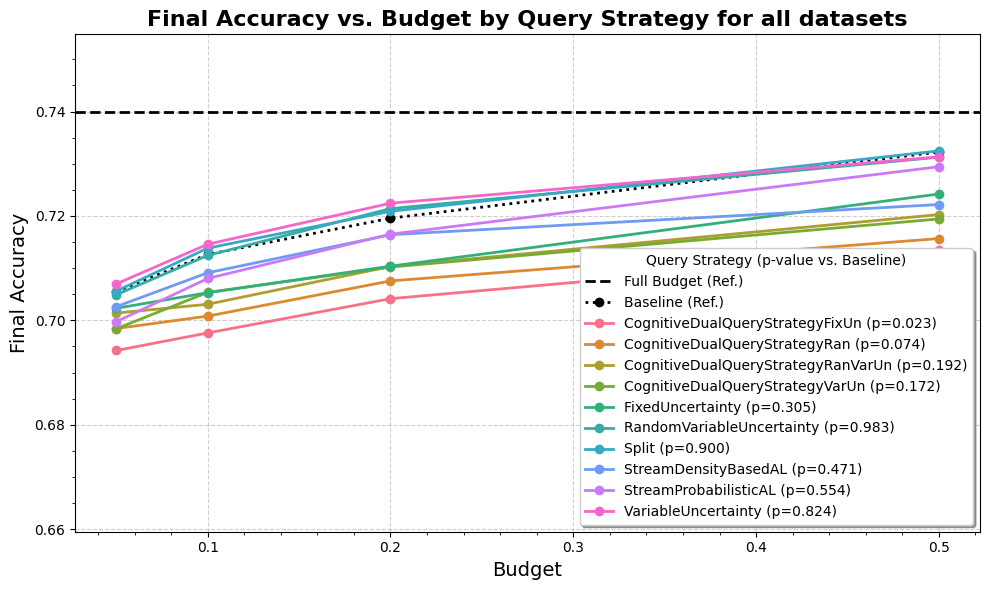

In [21]:
df_union_new = unify_query_strategies(df_union)
plot_accuracy_vs_budget(df_union_new, calculate_p_values(df_union_new), 'all')

## CC18


--- Calculated P-Values (vs. Baseline) ---
{'FixedUncertainty': '0.6396', 'VariableUncertainty': '0.7006', 'Split': '0.8433', 'StreamProbabilisticAL': '0.9317', 'RandomVariableUncertainty': '0.9799', 'StreamDensityBasedAL': '0.4420', 'CognitiveDualQueryStrategyRan': '0.0937', 'CognitiveDualQueryStrategyFixUn': '0.1146', 'CognitiveDualQueryStrategyRanVarUn': '0.2358', 'CognitiveDualQueryStrategyVarUn': '0.2714', 'NONE: BUDGET = 1': '0.0733', 'Baseline': '1.0000'}
------------------------------------------


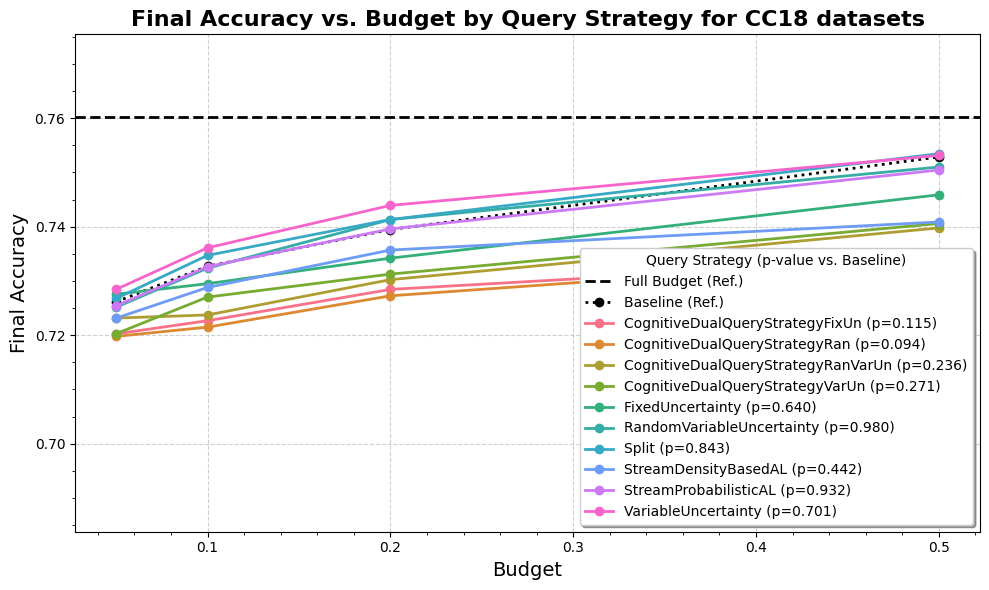

In [22]:
df_cc18_new =  unify_query_strategies(df_cc18)
plot_accuracy_vs_budget(df_cc18_new, calculate_p_values(df_cc18_new), 'CC18')

## Synth MOA


--- Calculated P-Values (vs. Baseline) ---
{'FixedUncertainty': '0.3123', 'VariableUncertainty': '0.7202', 'Split': '0.8388', 'StreamProbabilisticAL': '0.3183', 'RandomVariableUncertainty': '0.9927', 'StreamDensityBasedAL': '0.8475', 'CognitiveDualQueryStrategyRan': '0.4503', 'CognitiveDualQueryStrategyFixUn': '0.0997', 'CognitiveDualQueryStrategyRanVarUn': '0.5106', 'CognitiveDualQueryStrategyVarUn': '0.3296', 'NONE: BUDGET = 1': '0.4510', 'Baseline': '1.0000'}
------------------------------------------


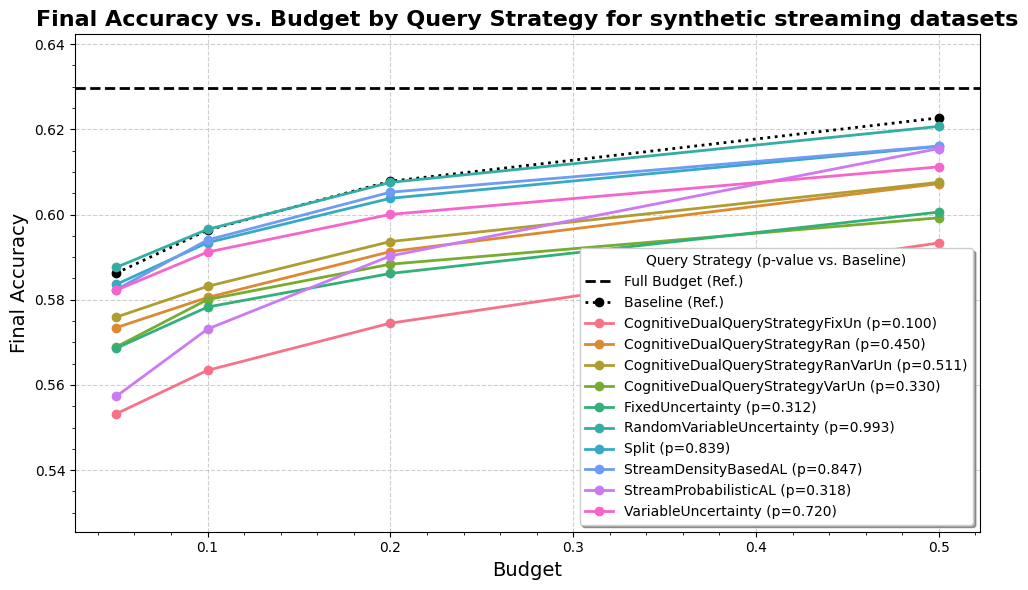

In [23]:
df_synth_moa_new =  unify_query_strategies(df_synth_moa)
plot_accuracy_vs_budget(df_synth_moa_new, calculate_p_values(df_synth_moa_new), 'synthetic streaming')

## Real MOA


--- Calculated P-Values (vs. Baseline) ---
{'FixedUncertainty': '0.0700', 'VariableUncertainty': '0.8043', 'Split': '0.8813', 'StreamProbabilisticAL': '0.1916', 'RandomVariableUncertainty': '0.9955', 'StreamDensityBasedAL': '0.9642', 'CognitiveDualQueryStrategyRan': '0.7426', 'CognitiveDualQueryStrategyFixUn': '0.0498', 'CognitiveDualQueryStrategyRanVarUn': '0.7597', 'CognitiveDualQueryStrategyVarUn': '0.6445', 'NONE: BUDGET = 1': '0.8485', 'Baseline': '1.0000'}
------------------------------------------


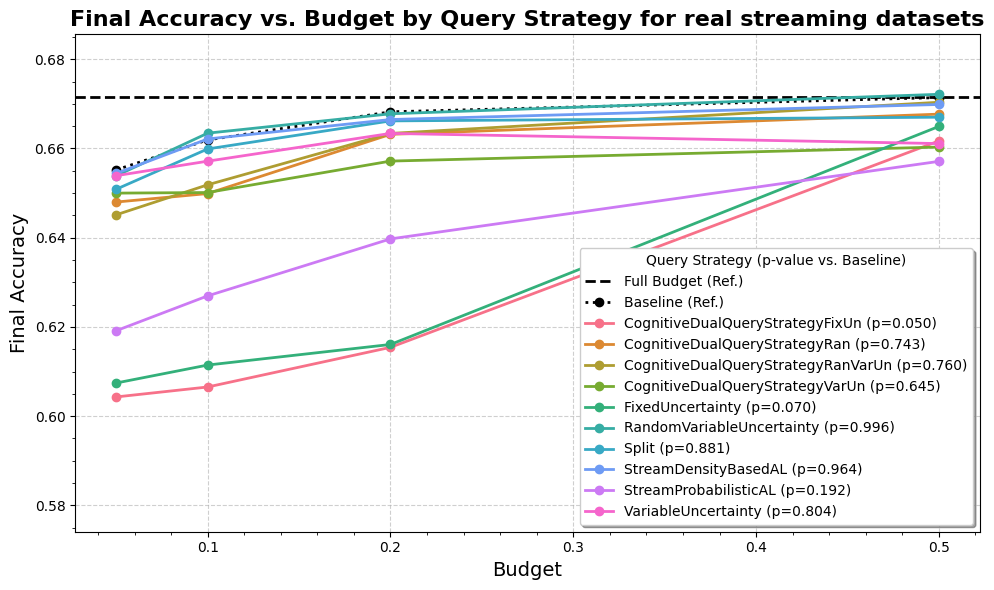

In [24]:
df_real_moa_new =  unify_query_strategies(df_real_moa)
plot_accuracy_vs_budget(df_real_moa_new, calculate_p_values(df_real_moa_new), 'real streaming')

## Budgets


--- Calculated P-Values (vs. Baseline) ---
Budget=0.05:  FixedUncertainty p=0.808 | VariableUncertainty p=0.910 | Split p=0.994 | StreamProbabilisticAL p=0.661 | RandomVariableUncertainty p=0.963 | StreamDensityBasedAL p=0.825 | CognitiveDualQueryStrategyRan p=0.585 | CognitiveDualQueryStrategyFixUn p=0.389 | CognitiveDualQueryStrategyRanVarUn p=0.751 | CognitiveDualQueryStrategyVarUn p=0.585 | NONE: BUDGET = 1 p=N/A |
Budget=0.1:  FixedUncertainty p=0.581 | VariableUncertainty p=0.882 | Split p=0.927 | StreamProbabilisticAL p=0.727 | RandomVariableUncertainty p=0.989 | StreamDensityBasedAL p=0.789 | CognitiveDualQueryStrategyRan p=0.367 | CognitiveDualQueryStrategyFixUn p=0.254 | CognitiveDualQueryStrategyRanVarUn p=0.468 | CognitiveDualQueryStrategyVarUn p=0.579 | NONE: BUDGET = 1 p=N/A |
Budget=0.2:  FixedUncertainty p=0.493 | VariableUncertainty p=0.830 | Split p=0.922 | StreamProbabilisticAL p=0.818 | RandomVariableUncertainty p=0.890 | StreamDensityBasedAL p=0.813 | CognitiveDua

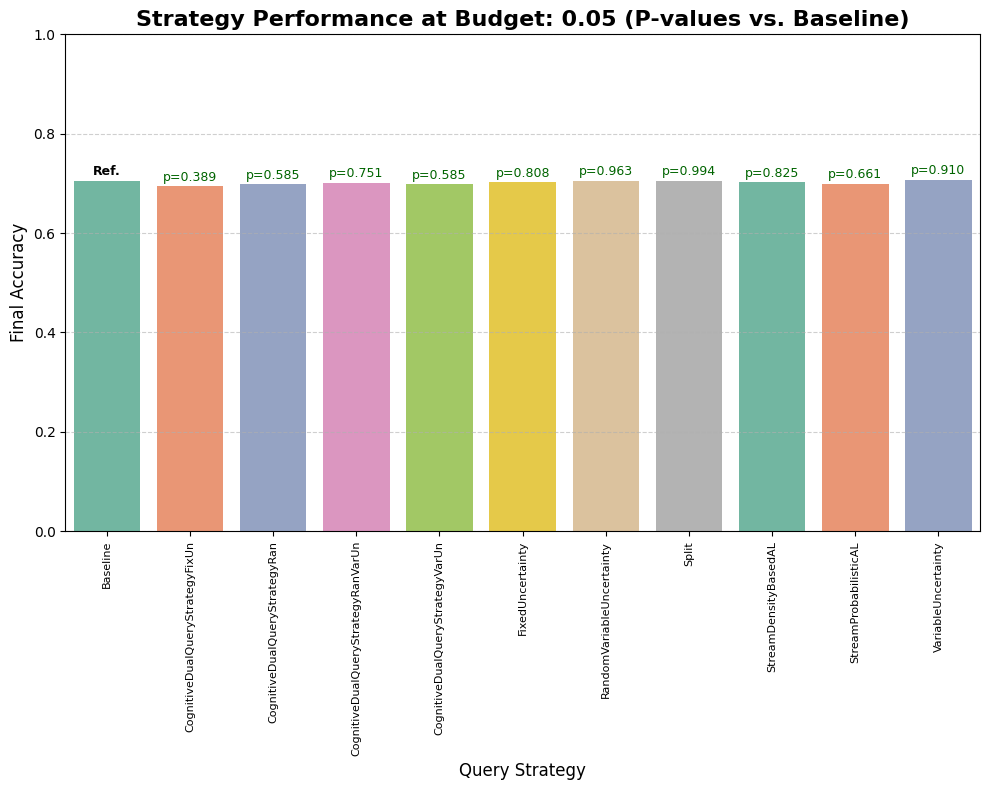

In [25]:
p_values_per_budget = calculate_p_values_per_budget(df_union_new)
plot_strategies_per_budget(df_union_new, p_values_per_budget, 0.05)

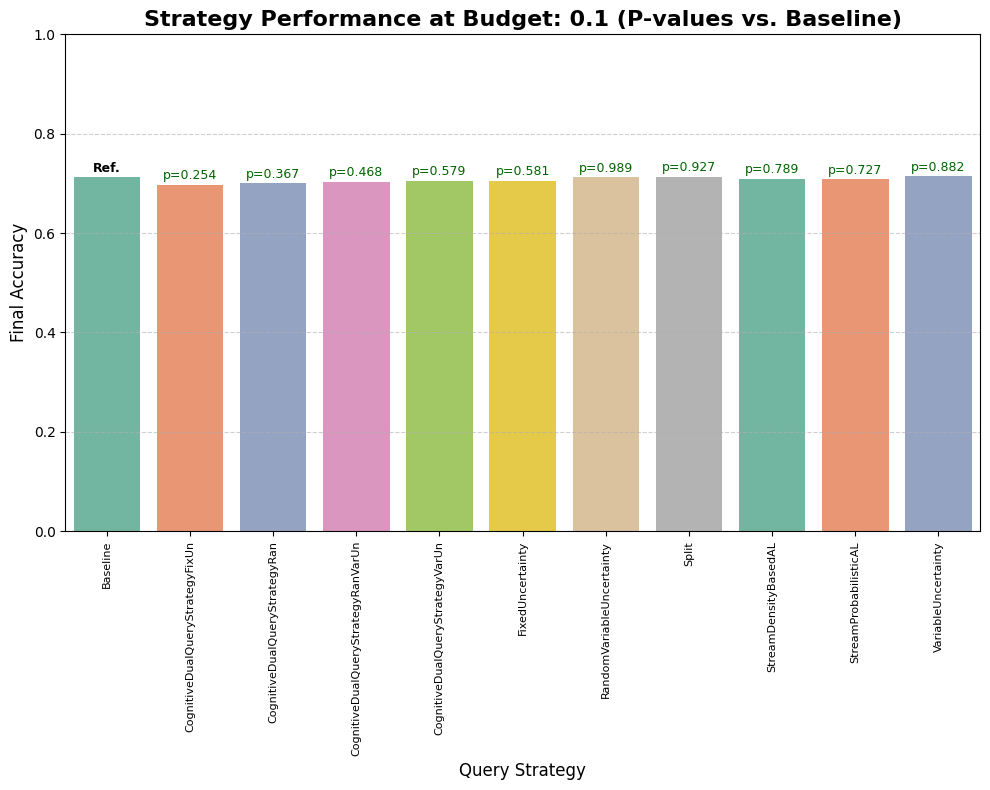

In [26]:
plot_strategies_per_budget(df_union_new, p_values_per_budget, 0.1)

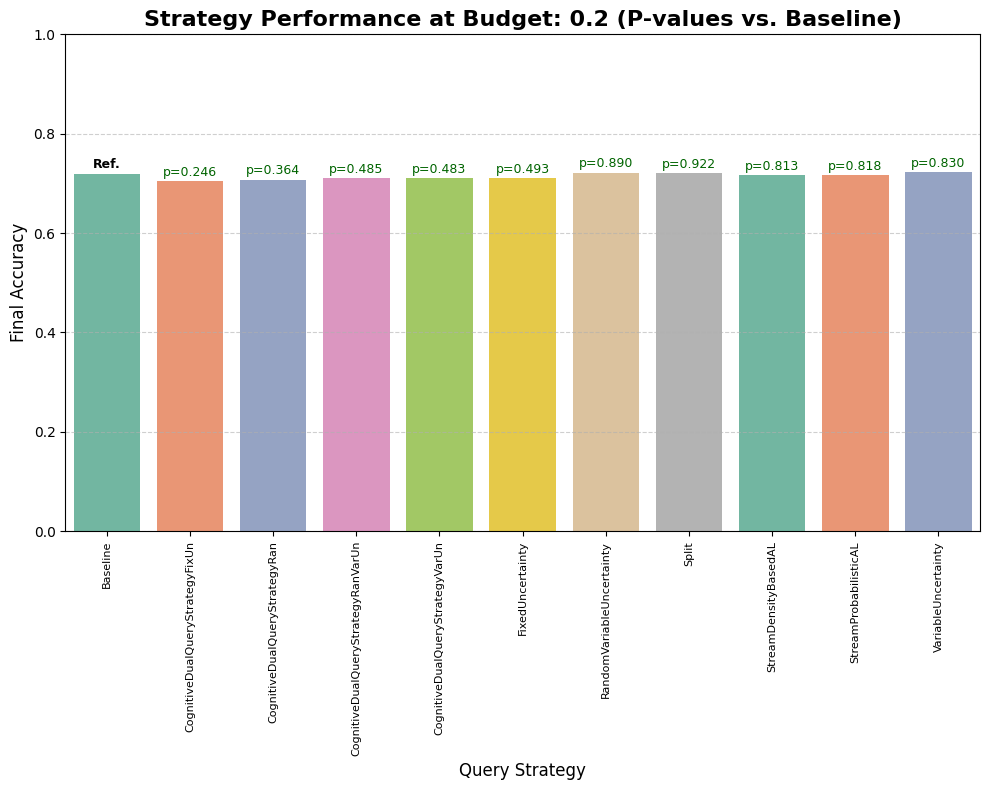

In [27]:
plot_strategies_per_budget(df_union_new, p_values_per_budget, 0.2)

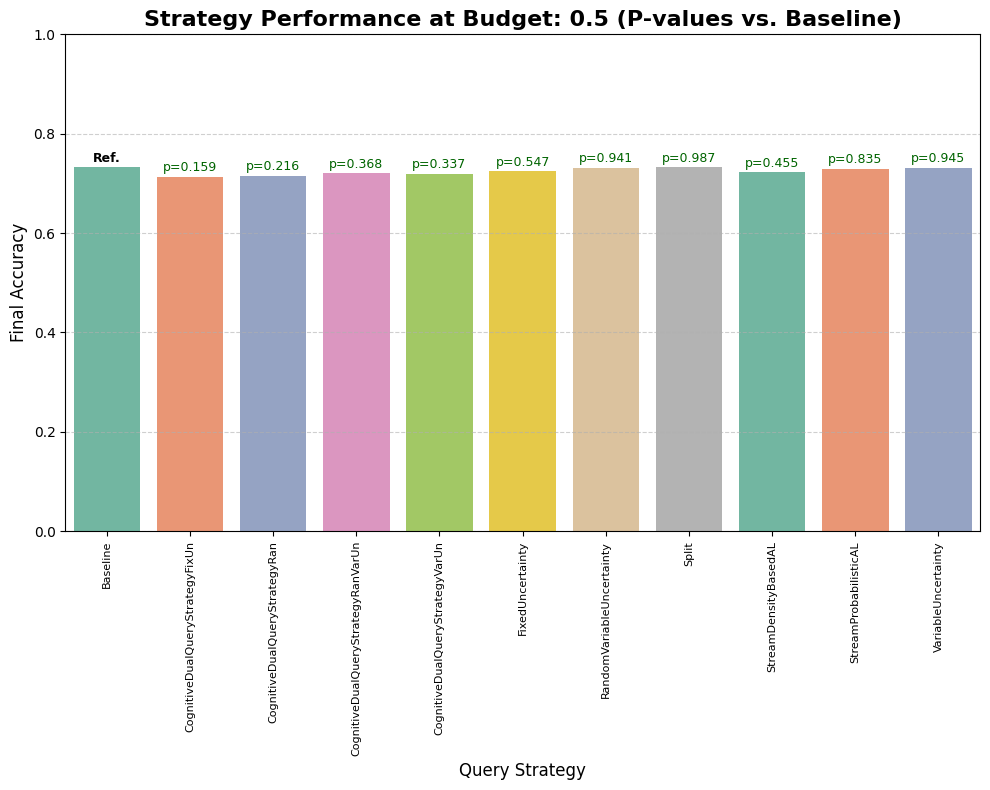

In [28]:
plot_strategies_per_budget(df_union_new, p_values_per_budget, 0.5)

## Models

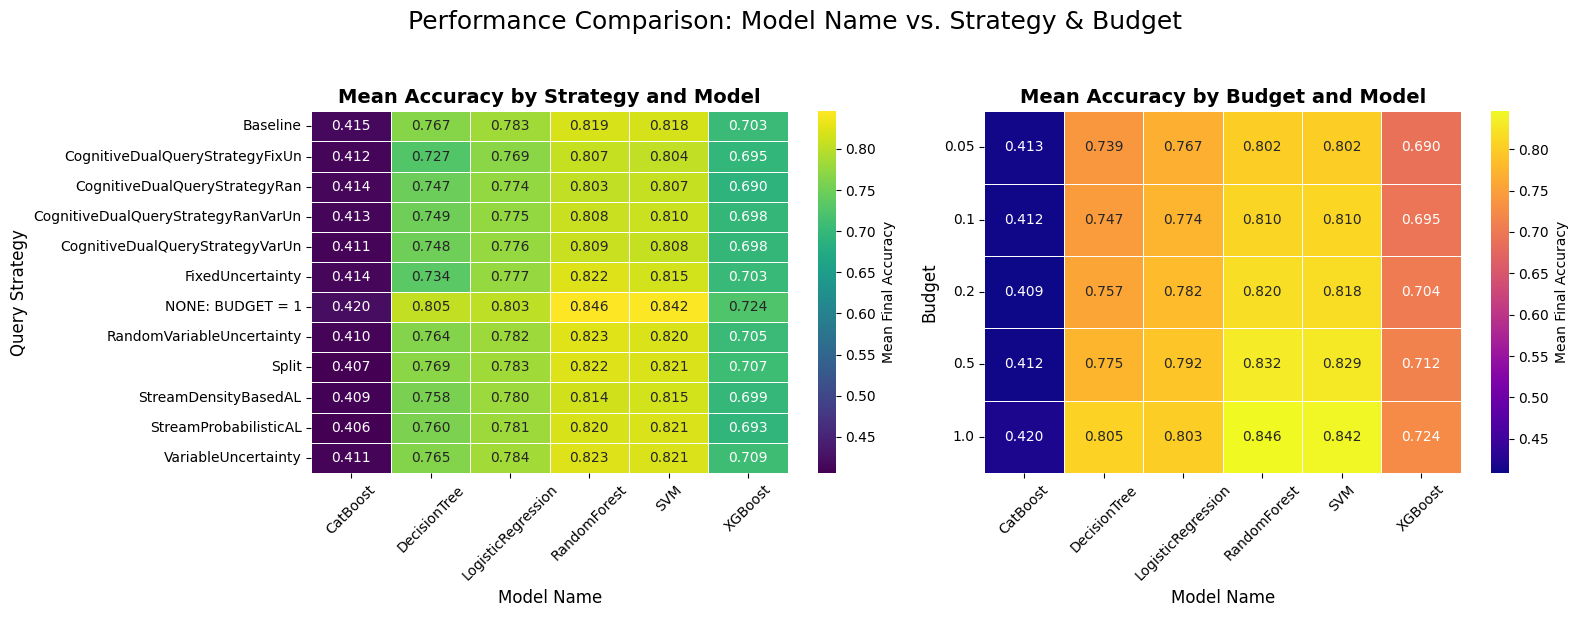

In [29]:
plot_heatmaps_by_model(df_union_new)